# Automating Forecasting at Scale

#### Loading Libraries

In [77]:
# Numerical Computing
import numpy as np
# Data Manipulation
import pandas as pd
from pandas.tseries.offsets import MonthEnd
# Data Visualization
import matplotlib.pyplot as plt

# Time Series Forecasting
from prophet import Prophet
# Metrics
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
# Plots
from prophet.plot import plot_cross_validation_metric
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_yearly, plot_weekly
from prophet.plot import add_changepoints_to_plot

# Warnings
import warnings

# TQDM Notebook
from tqdm.notebook import tqdm

# Itertools
from itertools import product
from typing import Union

# Machine Learning Metrics
from sklearn.metrics import mean_absolute_error

# Statsmodels
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [2]:
warnings.filterwarnings('ignore')

##### Visualization Set Up

In [3]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = True

#### Loading Data

In [4]:
df = pd.read_csv('/Users/isisromero/desktop/time_series/data/daily_min_temp.csv')

df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [5]:
df.tail()

,Date,Temp
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7
3649,1990-12-31,13.0


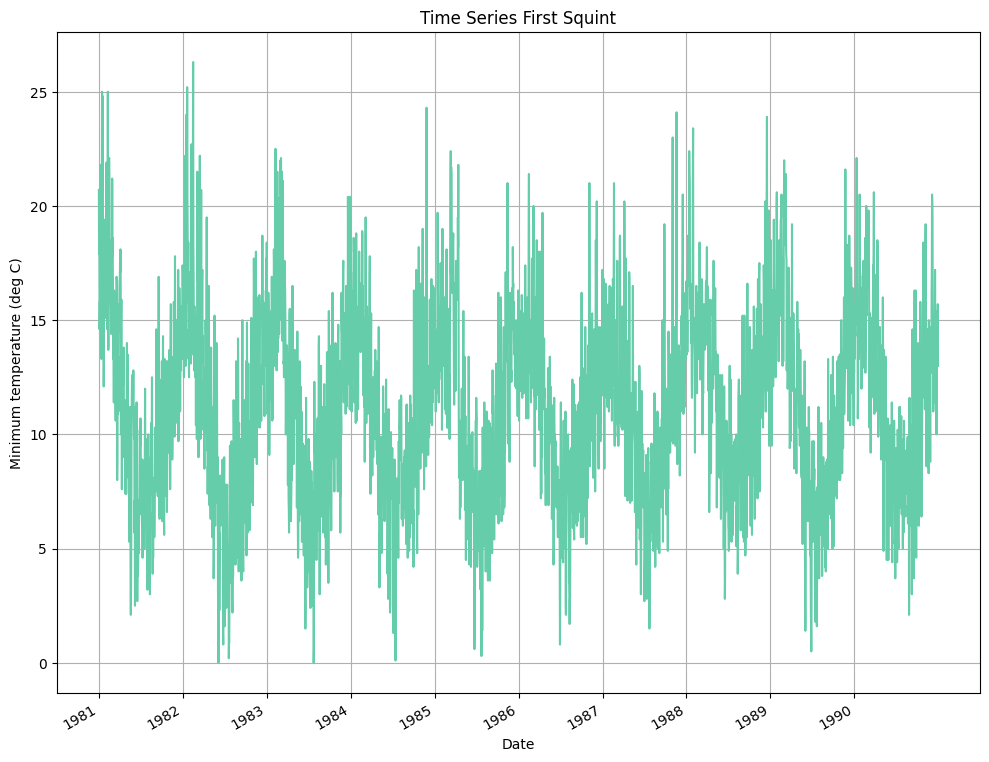

In [6]:
fig, ax = plt.subplots()

ax.plot(df['Temp'], color='mediumaquamarine')
ax.set_xlabel('Date')
ax.set_ylabel('Minimum temperature (deg C)')

plt.xticks(np.arange(0, 3649, 365), np.arange(1981, 1991, 1))

fig.autofmt_xdate()
plt.tight_layout()
plt.title('Time Series First Squint')
plt.show()

### Basic forecasting with Prophet

##### Renaming Columns

In [7]:
df.columns = ['ds', 'y']
df.head()

,ds,y
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


##### Split & Train Procedure

In [8]:
# Train set
train = df[:-365]
# Test set
test = df[-365:]

In [9]:
# Model Initialization
m = Prophet()

In [10]:
# Fitting & Training Model
m.fit(train);

08:12:38 - cmdstanpy - INFO - Chain [1] start processing
08:12:38 - cmdstanpy - INFO - Chain [1] done processing


##### Setting a Prediction DataFrame

In [11]:
# Make Future DataFrame
future = m.make_future_dataframe(periods=365)

##### Generating Predictions

In [12]:
# Predictions 
forecast = m.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-365:-360]

,ds,yhat,yhat_lower,yhat_upper
3285,1990-01-01,14.884813,11.544730,18.601520
3286,1990-01-02,15.011285,11.388136,18.530135
3287,1990-01-03,15.087727,11.344444,18.289867
3288,1990-01-04,14.995843,11.507113,18.908186
3289,1990-01-05,15.066143,11.561203,18.439125


In [13]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3645,1990-12-27,11.408331,11.113931,18.021765,11.308593,11.501093,3.043486,3.043486,3.043486,-0.026437,-0.026437,-0.026437,3.069923,3.069923,3.069923,0.0,0.0,0.0,14.451816
3646,1990-12-28,11.408249,10.922768,18.097229,11.308125,11.501443,3.120829,3.120829,3.120829,-0.009961,-0.009961,-0.009961,3.130790,3.130790,3.130790,0.0,0.0,0.0,14.529079
3647,1990-12-29,11.408168,11.137558,18.077459,11.307656,11.501795,3.144904,3.144904,3.144904,-0.048861,-0.048861,-0.048861,3.193765,3.193765,3.193765,0.0,0.0,0.0,14.553072
3648,1990-12-30,11.408086,11.028190,18.002730,11.307197,11.502174,3.069384,3.069384,3.069384,-0.188709,-0.188709,-0.188709,3.258093,3.258093,3.258093,0.0,0.0,0.0,14.477471
3649,1990-12-31,11.408005,11.254357,18.276527,11.306746,11.502449,3.366622,3.366622,3.366622,0.043661,0.043661,0.043661,3.322962,3.322962,3.322962,0.0,0.0,0.0,14.774627


##### Forecasting with Test

In [14]:
# Joining test to set a single DataFrame
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
test.head()

,ds,y,yhat,yhat_lower,yhat_upper
3285,1990-01-01,14.8,14.884813,11.544730,18.601520
3286,1990-01-02,13.3,15.011285,11.388136,18.530135
3287,1990-01-03,15.6,15.087727,11.344444,18.289867
3288,1990-01-04,14.5,14.995843,11.507113,18.908186
3289,1990-01-05,14.3,15.066143,11.561203,18.439125


##### Setting Baseline Benchmark Model

In [15]:
test['baseline'] = train['y'][-365:].values
test.head()

,ds,y,yhat,yhat_lower,yhat_upper,baseline
3285,1990-01-01,14.8,14.884813,11.544730,18.601520,14.3
3286,1990-01-02,13.3,15.011285,11.388136,18.530135,17.4
3287,1990-01-03,15.6,15.087727,11.344444,18.289867,18.5
3288,1990-01-04,14.5,14.995843,11.507113,18.908186,16.8
3289,1990-01-05,14.3,15.066143,11.561203,18.439125,11.5


##### Setting Interpretability Model Metrics with (MAE)

In [16]:
# Mean Absolute Error on Prophet
prophet_mae = mean_absolute_error(test['y'], test['yhat'])
baseline_mae = mean_absolute_error(test['y'], test['baseline'])

In [17]:
# Metric Outcomes
print(prophet_mae)
print(baseline_mae)

1.9372369140969206
2.8673972602739726


In [18]:
test.iloc[33]

ds            1990-02-03
y                   14.8
yhat           15.445169
yhat_lower     11.907034
yhat_upper     19.002874
baseline            16.3
Name: 3318, dtype: object

##### Forecast & Confidence Interval Visualization

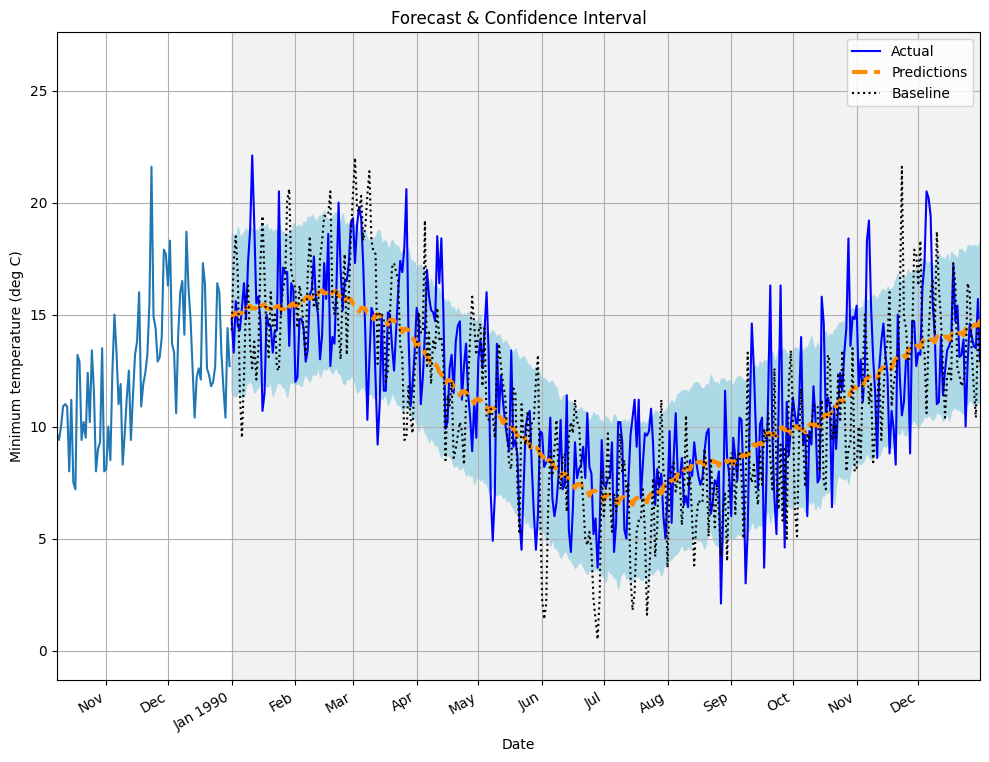

In [19]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Predictions')
ax.plot(test['baseline'], 'k:', label='Baseline')

ax.set_xlabel('Date')
ax.set_ylabel('Minimum temperature (deg C)')

ax.axvspan(3285, 3649, color='#808080', alpha=0.1)

ax.legend(loc='best')

plt.xticks(
    [3224, 3254, 3285, 3316, 3344, 3375, 3405, 3436, 3466, 3497, 3528, 3558, 3589, 3619],
    ['Nov', 'Dec', 'Jan 1990', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(3200, 3649)

fig.autofmt_xdate()
plt.tight_layout()
plt.title('Forecast & Confidence Interval')
plt.show()

### Prophet's Advance Functionality

##### Visualization Capabilities

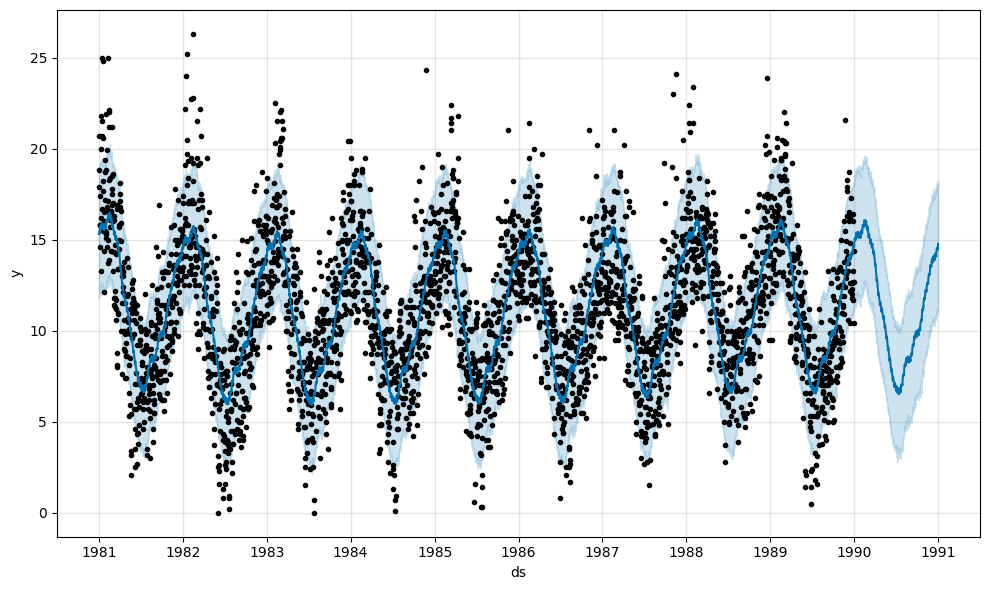

In [20]:
fig1 = m.plot(forecast)

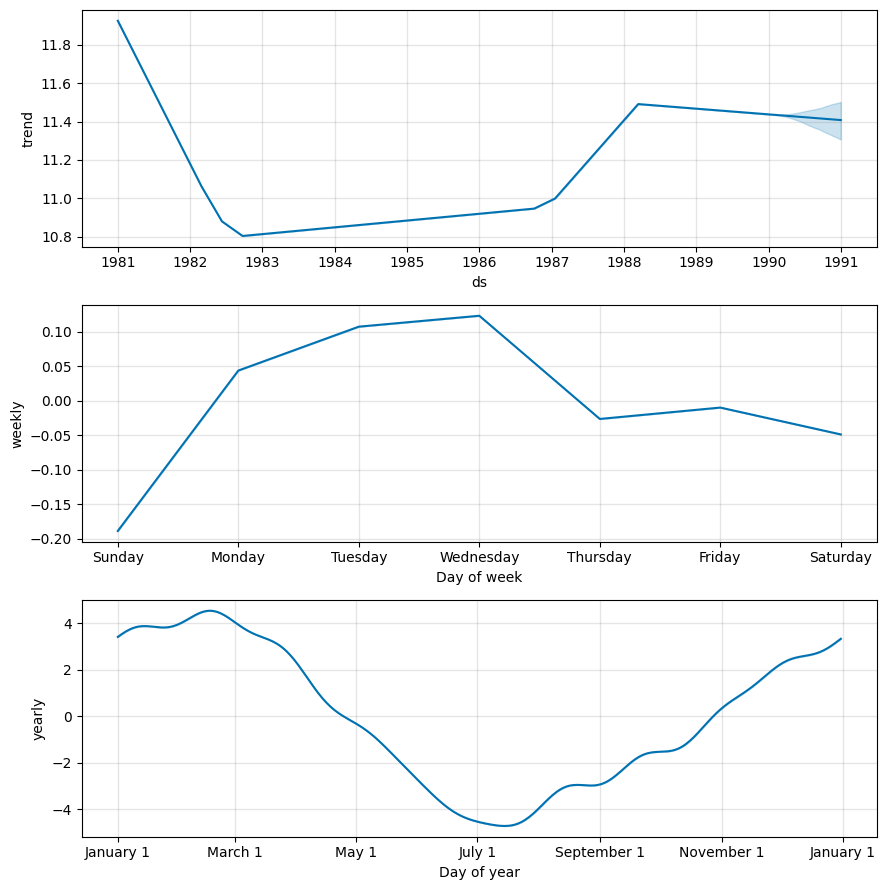

In [21]:
# Plotting Components
fig2 = m.plot_components(forecast)

##### Only Seasonal Component

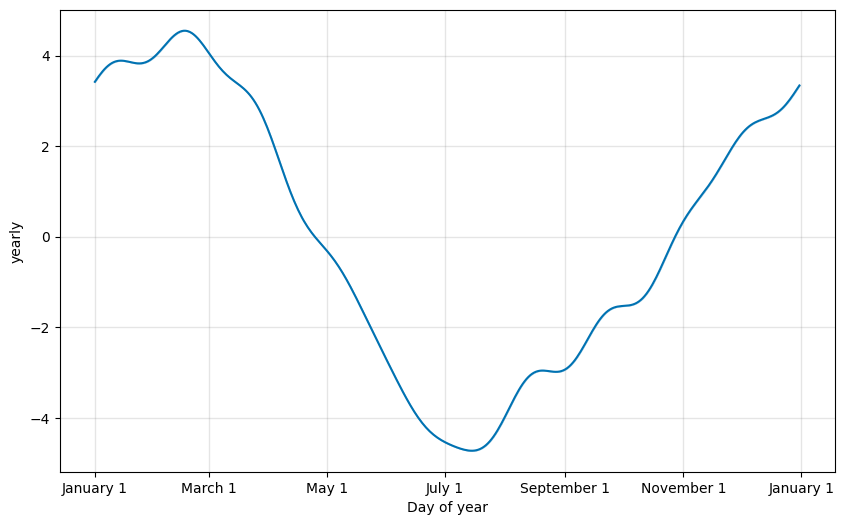

In [22]:
# Yearly
fig4 = plot_yearly(m)

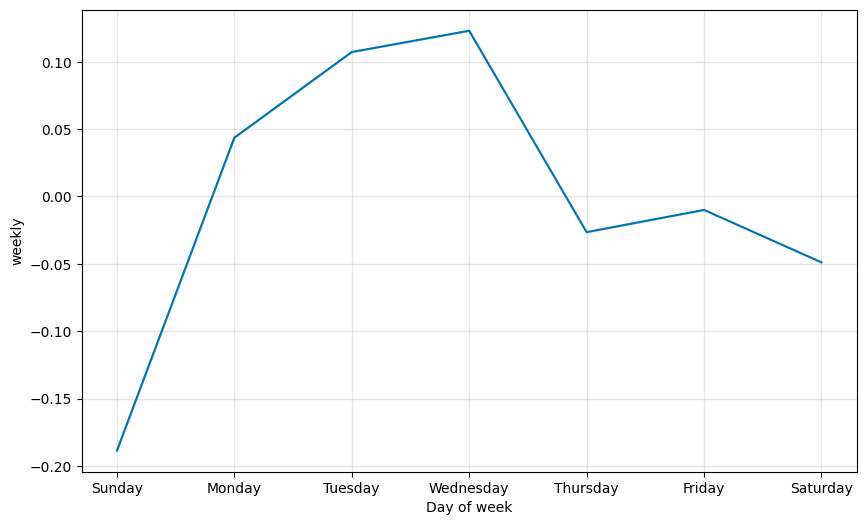

In [23]:
# Weekly
fig5 = plot_weekly(m)

08:12:52 - cmdstanpy - INFO - Chain [1] start processing
08:12:52 - cmdstanpy - INFO - Chain [1] done processing


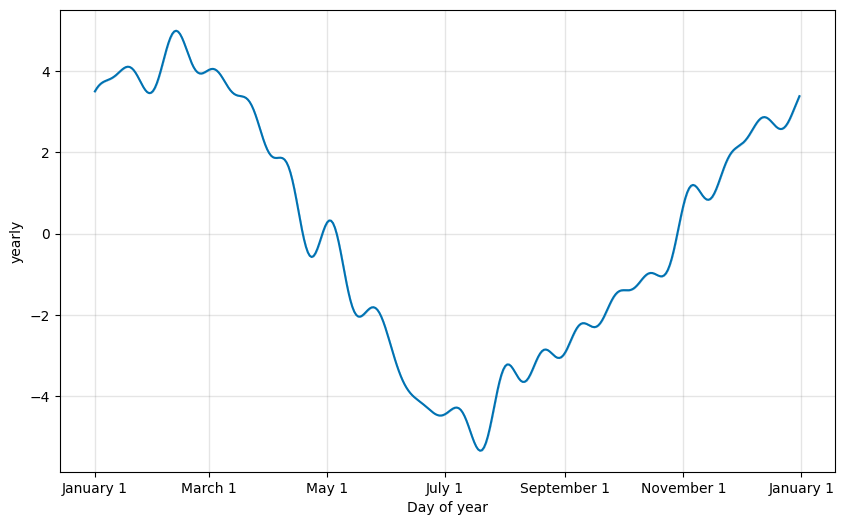

In [24]:
# Based on 20 seasonal terms
m2 = Prophet(yearly_seasonality=20).fit(train)

fig6 = plot_yearly(m2)

#### Identifying Unique Trends

##### Trend's Changepoint

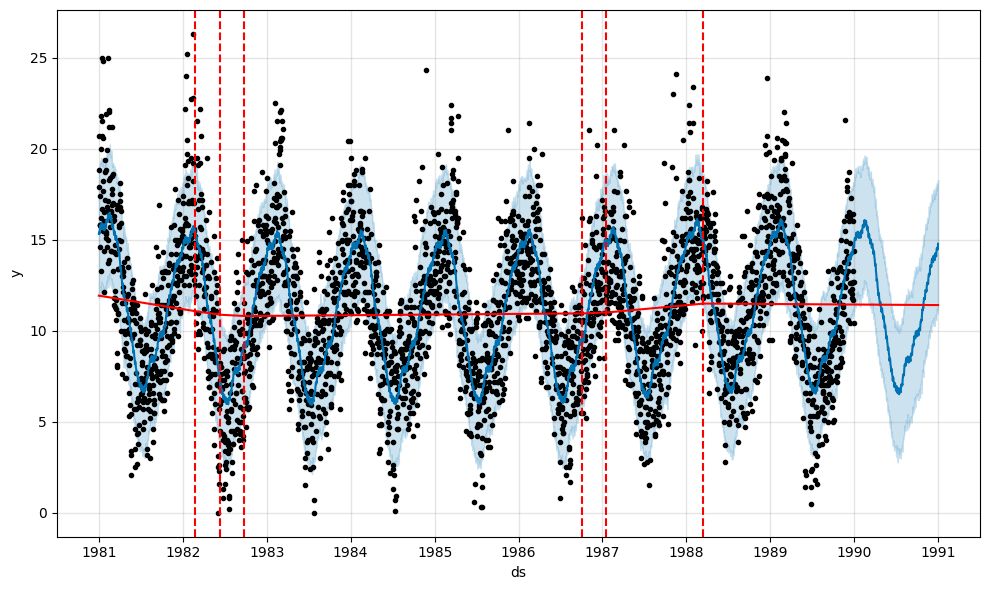

In [25]:
fig3 = m.plot(forecast)
# Changepoint's to plot
a = add_changepoints_to_plot(fig3.gca(), m, forecast)

### Cross-Validation & Performance Metrics

#### Setting Data

In [26]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel='processes')

df_cv.head()

08:12:56 - cmdstanpy - INFO - Chain [1] start processing
08:12:56 - cmdstanpy - INFO - Chain [1] start processing
08:12:56 - cmdstanpy - INFO - Chain [1] done processing
08:12:56 - cmdstanpy - INFO - Chain [1] done processing
08:12:56 - cmdstanpy - INFO - Chain [1] start processing
08:12:56 - cmdstanpy - INFO - Chain [1] start processing
08:12:56 - cmdstanpy - INFO - Chain [1] start processing
08:12:56 - cmdstanpy - INFO - Chain [1] start processing
08:12:56 - cmdstanpy - INFO - Chain [1] start processing
08:12:56 - cmdstanpy - INFO - Chain [1] start processing
08:12:56 - cmdstanpy - INFO - Chain [1] done processing
08:12:57 - cmdstanpy - INFO - Chain [1] done processing
08:12:57 - cmdstanpy - INFO - Chain [1] done processing
08:12:57 - cmdstanpy - INFO - Chain [1] done processing
08:12:57 - cmdstanpy - INFO - Chain [1] done processing
08:12:57 - cmdstanpy - INFO - Chain [1] start processing
08:12:57 - cmdstanpy - INFO - Chain [1] start processing
08:12:57 - cmdstanpy - INFO - Chain [1

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1983-02-02,15.180760,11.908360,18.892888,17.3,1983-02-01
1,1983-02-03,14.843227,11.213881,18.324723,13.0,1983-02-01
2,1983-02-04,15.238653,11.717714,18.832094,16.0,1983-02-01
3,1983-02-05,15.230166,11.848789,18.735445,14.9,1983-02-01
4,1983-02-06,15.277526,12.052221,18.781865,16.2,1983-02-01


##### Model Performance Evaluation

In [27]:
df_perf = performance_metrics(df_cv, rolling_window=0)

df_perf.head()

,horizon,mse,rmse,mae,mdape,smape,coverage
0,1 days,6.343070,2.518545,2.070920,0.150126,0.198579,0.846154
1,2 days,4.688372,2.165265,1.746947,0.141787,0.161501,0.846154
2,3 days,10.002355,3.162650,2.657245,0.146937,0.371581,0.769231
3,4 days,8.643322,2.939953,2.374467,0.195721,0.328718,0.769231
4,5 days,8.195715,2.862816,2.560727,0.195882,0.300317,0.615385


##### Horizon Metric Evaluation

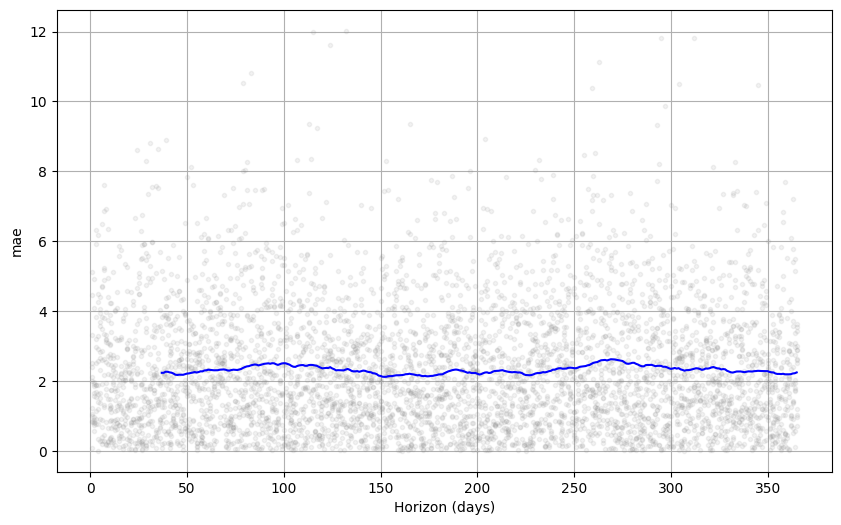

In [28]:
fig7 = plot_cross_validation_metric(df_cv, metric='mae')

### Hyperparameter Tuning

In [29]:
# Parameters Grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# List of Unique Parameters Combination
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

maes = []

# Unique Iteration Steps
for params in all_params:
    m = Prophet(**params).fit(train)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Setting Results within a DataFrame
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes

tuning_results

08:13:02 - cmdstanpy - INFO - Chain [1] start processing
08:13:02 - cmdstanpy - INFO - Chain [1] done processing
08:13:03 - cmdstanpy - INFO - Chain [1] start processing
08:13:03 - cmdstanpy - INFO - Chain [1] done processing
08:13:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:13:03 - cmdstanpy - INFO - Chain [1] start processing
08:13:03 - cmdstanpy - INFO - Chain [1] start processing
08:13:03 - cmdstanpy - INFO - Chain [1] start processing
08:13:03 - cmdstanpy - INFO - Chain [1] start processing
08:13:03 - cmdstanpy - INFO - Chain [1] start processing
08:13:03 - cmdstanpy - INFO - Chain [1] done processing
08:13:03 - cmdstanpy - INFO - Chain [1] start processing
08:13:03 - cmdstanpy - INFO - Chain [1] start processing
08:13:03 - cmdstanpy - INFO - Chain [1] done processing
08:13:03 - cmdstanpy - INFO - Chain [1] done processing
08:13:03 - cmdstanpy - INFO - Chain [1] start proce

,changepoint_prior_scale,seasonality_prior_scale,mae
0,0.001,0.01,2.312803
1,0.001,0.10,2.313993
2,0.001,1.00,2.342393
3,0.001,10.00,2.341224
4,0.010,0.01,2.240415
5,0.010,0.10,2.278294
6,0.010,1.00,2.276686
7,0.010,10.00,2.280470
8,0.100,0.01,2.668172
9,0.100,0.10,2.346970


In [30]:
best_params = all_params[np.argmin(maes)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


### Implementing a Robust Forecasting Process with Prophet

#### Forecasting project: Predicting the popularity of "chocolate" searches on Google

Source: https://trends.google.com/trends/explore?date=all&geo=US&q=chocolate

In [46]:
df = pd.read_csv('/Users/isisromero/desktop/time_series/data/monthly_chocolate_search_usa.csv')
df.head()

,month,chocolate
0,2004-01,35
1,2004-02,48
2,2004-03,34
3,2004-04,33
4,2004-05,33


##### 1st Plotting Forecast Diagnose

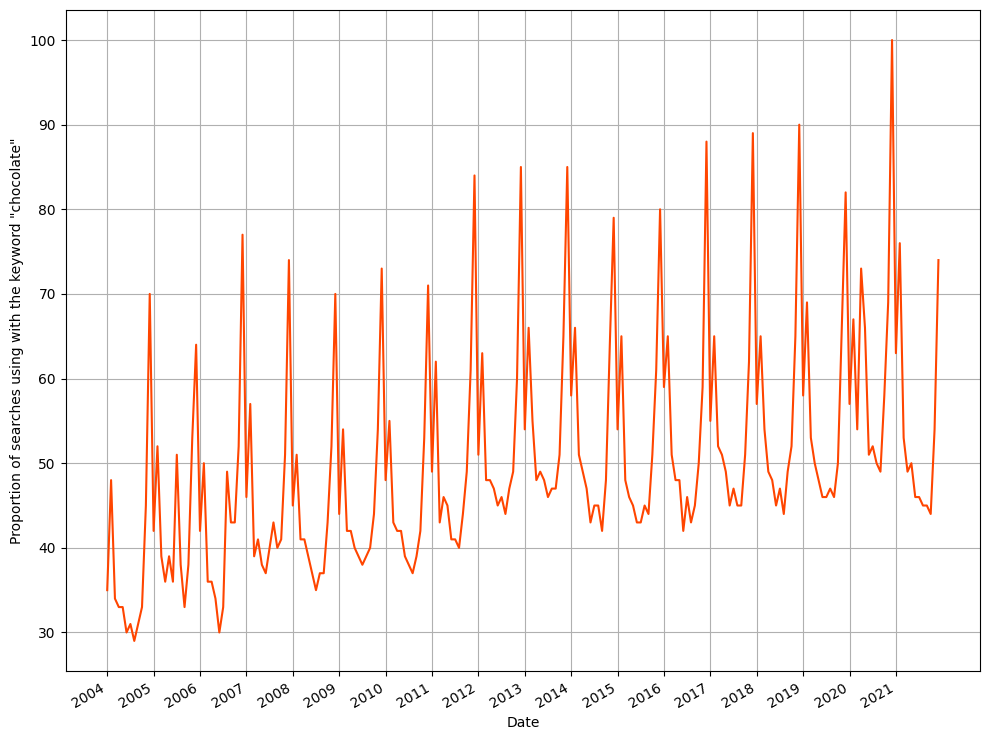

In [47]:
fig, ax = plt.subplots()

ax.plot(df['chocolate'], color='orangered')
ax.set_xlabel('Date')
ax.set_ylabel('Proportion of searches using with the keyword "chocolate"')

plt.xticks(np.arange(0, 215, 12), np.arange(2004, 2022, 1))

fig.autofmt_xdate()
plt.tight_layout()

##### Renaming Columns

In [48]:
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2004-01,35
1,2004-02,48
2,2004-03,34
3,2004-04,33
4,2004-05,33


##### Setting Date Formatted

In [49]:
df['ds'] = pd.to_datetime(df['ds']) + MonthEnd(1)

df.head()

,ds,y
0,2004-01-31,35
1,2004-02-29,48
2,2004-03-31,34
3,2004-04-30,33
4,2004-05-31,33


##### Splitting Data Procedure

In [50]:
# Train Set
train = df[:-12]
# Test set
test = df[-12:]

In [51]:
train.tail()

,ds,y
199,2020-08-31,50
200,2020-09-30,49
201,2020-10-31,58
202,2020-11-30,69
203,2020-12-31,100


##### Hyperparameter Tuning

In [53]:
# # Parameter Grid
# param_grid = {
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
# }

# # List of Unique Parameters Combination
# params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

# mses = []

# cutoffs = pd.date_range(start='2009-01-31', end='2020-01-31', freq='12M')

# # Unique Iteration Steps
# for param in params:
#     m = Prophet(**param)
#     m.add_country_holidays(country_name='US')
#     m.fit(train)
    
#     df_cv = cross_validation(model=m, horizon='365 days', cutoffs=cutoffs)
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     mses.append(df_p['mse'].values[0])
    
# # Setting Results within a DataFrame
# tuning_results = pd.DataFrame(params)
# tuning_results['mse'] = mses

In [52]:
# Parameter Grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# List of Unique Parameters Combination
params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

mses = []

last_train_date = train['ds'].max()
cutoffs_end_date = last_train_date - pd.Timedelta(days=365)
cutoffs = pd.date_range(start='2009-01-31', end=cutoffs_end_date, freq='12M')

mses = []

for param in params:
    m = Prophet(**param)
    m.add_country_holidays(country_name='US')
    m.fit(train)
    
    df_cv = cross_validation(model=m, horizon='365 days', cutoffs=cutoffs)
    df_p = performance_metrics(df_cv, rolling_window=1)
    mses.append(df_p['mse'].values[0])
    
tuning_results = pd.DataFrame(params)
tuning_results['mse'] = mses

09:43:16 - cmdstanpy - INFO - Chain [1] start processing
09:43:16 - cmdstanpy - INFO - Chain [1] done processing
09:43:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:43:16 - cmdstanpy - INFO - Chain [1] start processing
09:43:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/11 [00:00<?, ?it/s]

09:43:17 - cmdstanpy - INFO - Chain [1] start processing
09:43:17 - cmdstanpy - INFO - Chain [1] done processing
09:43:17 - cmdstanpy - INFO - Chain [1] start processing
09:43:17 - cmdstanpy - INFO - Chain [1] done processing
09:43:17 - cmdstanpy - INFO - Chain [1] start processing
09:43:18 - cmdstanpy - INFO - Chain [1] done processing
09:43:18 - cmdstanpy - INFO - Chain [1] start processing
09:43:18 - cmdstanpy - INFO - Chain [1] done processing
09:43:18 - cmdstanpy - INFO - Chain [1] start processing
09:43:18 - cmdstanpy - INFO - Chain [1] done processing
09:43:18 - cmdstanpy - INFO - Chain [1] start processing
09:43:18 - cmdstanpy - INFO - Chain [1] done processing
09:43:18 - cmdstanpy - INFO - Chain [1] start processing
09:43:18 - cmdstanpy - INFO - Chain [1] done processing
09:43:18 - cmdstanpy - INFO - Chain [1] start processing
09:43:18 - cmdstanpy - INFO - Chain [1] done processing
09:43:18 - cmdstanpy - INFO - Chain [1] start processing
09:43:18 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

09:43:18 - cmdstanpy - INFO - Chain [1] start processing
09:43:19 - cmdstanpy - INFO - Chain [1] done processing
09:43:19 - cmdstanpy - INFO - Chain [1] start processing
09:43:19 - cmdstanpy - INFO - Chain [1] done processing
09:43:19 - cmdstanpy - INFO - Chain [1] start processing
09:43:19 - cmdstanpy - INFO - Chain [1] done processing
09:43:19 - cmdstanpy - INFO - Chain [1] start processing
09:43:19 - cmdstanpy - INFO - Chain [1] done processing
09:43:19 - cmdstanpy - INFO - Chain [1] start processing
09:43:19 - cmdstanpy - INFO - Chain [1] done processing
09:43:19 - cmdstanpy - INFO - Chain [1] start processing
09:43:19 - cmdstanpy - INFO - Chain [1] done processing
09:43:19 - cmdstanpy - INFO - Chain [1] start processing
09:43:19 - cmdstanpy - INFO - Chain [1] done processing
09:43:19 - cmdstanpy - INFO - Chain [1] start processing
09:43:19 - cmdstanpy - INFO - Chain [1] done processing
09:43:19 - cmdstanpy - INFO - Chain [1] start processing
09:43:19 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

09:43:20 - cmdstanpy - INFO - Chain [1] start processing
09:43:20 - cmdstanpy - INFO - Chain [1] done processing
09:43:20 - cmdstanpy - INFO - Chain [1] start processing
09:43:20 - cmdstanpy - INFO - Chain [1] done processing
09:43:20 - cmdstanpy - INFO - Chain [1] start processing
09:43:20 - cmdstanpy - INFO - Chain [1] done processing
09:43:20 - cmdstanpy - INFO - Chain [1] start processing
09:43:20 - cmdstanpy - INFO - Chain [1] done processing
09:43:20 - cmdstanpy - INFO - Chain [1] start processing
09:43:20 - cmdstanpy - INFO - Chain [1] done processing
09:43:20 - cmdstanpy - INFO - Chain [1] start processing
09:43:20 - cmdstanpy - INFO - Chain [1] done processing
09:43:20 - cmdstanpy - INFO - Chain [1] start processing
09:43:20 - cmdstanpy - INFO - Chain [1] done processing
09:43:20 - cmdstanpy - INFO - Chain [1] start processing
09:43:21 - cmdstanpy - INFO - Chain [1] done processing
09:43:21 - cmdstanpy - INFO - Chain [1] start processing
09:43:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

09:43:21 - cmdstanpy - INFO - Chain [1] start processing
09:43:21 - cmdstanpy - INFO - Chain [1] done processing
09:43:21 - cmdstanpy - INFO - Chain [1] start processing
09:43:21 - cmdstanpy - INFO - Chain [1] done processing
09:43:21 - cmdstanpy - INFO - Chain [1] start processing
09:43:21 - cmdstanpy - INFO - Chain [1] done processing
09:43:21 - cmdstanpy - INFO - Chain [1] start processing
09:43:22 - cmdstanpy - INFO - Chain [1] done processing
09:43:22 - cmdstanpy - INFO - Chain [1] start processing
09:43:22 - cmdstanpy - INFO - Chain [1] done processing
09:43:22 - cmdstanpy - INFO - Chain [1] start processing
09:43:22 - cmdstanpy - INFO - Chain [1] done processing
09:43:22 - cmdstanpy - INFO - Chain [1] start processing
09:43:22 - cmdstanpy - INFO - Chain [1] done processing
09:43:22 - cmdstanpy - INFO - Chain [1] start processing
09:43:22 - cmdstanpy - INFO - Chain [1] done processing
09:43:22 - cmdstanpy - INFO - Chain [1] start processing
09:43:22 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

09:43:22 - cmdstanpy - INFO - Chain [1] start processing
09:43:22 - cmdstanpy - INFO - Chain [1] done processing
09:43:22 - cmdstanpy - INFO - Chain [1] start processing
09:43:22 - cmdstanpy - INFO - Chain [1] done processing
09:43:22 - cmdstanpy - INFO - Chain [1] start processing
09:43:22 - cmdstanpy - INFO - Chain [1] done processing
09:43:22 - cmdstanpy - INFO - Chain [1] start processing
09:43:22 - cmdstanpy - INFO - Chain [1] done processing
09:43:22 - cmdstanpy - INFO - Chain [1] start processing
09:43:22 - cmdstanpy - INFO - Chain [1] done processing
09:43:23 - cmdstanpy - INFO - Chain [1] start processing
09:43:23 - cmdstanpy - INFO - Chain [1] done processing
09:43:23 - cmdstanpy - INFO - Chain [1] start processing
09:43:23 - cmdstanpy - INFO - Chain [1] done processing
09:43:23 - cmdstanpy - INFO - Chain [1] start processing
09:43:23 - cmdstanpy - INFO - Chain [1] done processing
09:43:23 - cmdstanpy - INFO - Chain [1] start processing
09:43:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

09:43:23 - cmdstanpy - INFO - Chain [1] start processing
09:43:23 - cmdstanpy - INFO - Chain [1] done processing
09:43:23 - cmdstanpy - INFO - Chain [1] start processing
09:43:23 - cmdstanpy - INFO - Chain [1] done processing
09:43:23 - cmdstanpy - INFO - Chain [1] start processing
09:43:23 - cmdstanpy - INFO - Chain [1] done processing
09:43:23 - cmdstanpy - INFO - Chain [1] start processing
09:43:23 - cmdstanpy - INFO - Chain [1] done processing
09:43:23 - cmdstanpy - INFO - Chain [1] start processing
09:43:24 - cmdstanpy - INFO - Chain [1] done processing
09:43:24 - cmdstanpy - INFO - Chain [1] start processing
09:43:24 - cmdstanpy - INFO - Chain [1] done processing
09:43:24 - cmdstanpy - INFO - Chain [1] start processing
09:43:24 - cmdstanpy - INFO - Chain [1] done processing
09:43:24 - cmdstanpy - INFO - Chain [1] start processing
09:43:24 - cmdstanpy - INFO - Chain [1] done processing
09:43:24 - cmdstanpy - INFO - Chain [1] start processing
09:43:24 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

09:43:24 - cmdstanpy - INFO - Chain [1] start processing
09:43:24 - cmdstanpy - INFO - Chain [1] done processing
09:43:24 - cmdstanpy - INFO - Chain [1] start processing
09:43:24 - cmdstanpy - INFO - Chain [1] done processing
09:43:24 - cmdstanpy - INFO - Chain [1] start processing
09:43:24 - cmdstanpy - INFO - Chain [1] done processing
09:43:24 - cmdstanpy - INFO - Chain [1] start processing
09:43:24 - cmdstanpy - INFO - Chain [1] done processing
09:43:24 - cmdstanpy - INFO - Chain [1] start processing
09:43:24 - cmdstanpy - INFO - Chain [1] done processing
09:43:25 - cmdstanpy - INFO - Chain [1] start processing
09:43:25 - cmdstanpy - INFO - Chain [1] done processing
09:43:25 - cmdstanpy - INFO - Chain [1] start processing
09:43:25 - cmdstanpy - INFO - Chain [1] done processing
09:43:25 - cmdstanpy - INFO - Chain [1] start processing
09:43:25 - cmdstanpy - INFO - Chain [1] done processing
09:43:25 - cmdstanpy - INFO - Chain [1] start processing
09:43:25 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

09:43:25 - cmdstanpy - INFO - Chain [1] start processing
09:43:25 - cmdstanpy - INFO - Chain [1] done processing
09:43:25 - cmdstanpy - INFO - Chain [1] start processing
09:43:25 - cmdstanpy - INFO - Chain [1] done processing
09:43:25 - cmdstanpy - INFO - Chain [1] start processing
09:43:25 - cmdstanpy - INFO - Chain [1] done processing
09:43:25 - cmdstanpy - INFO - Chain [1] start processing
09:43:25 - cmdstanpy - INFO - Chain [1] done processing
09:43:26 - cmdstanpy - INFO - Chain [1] start processing
09:43:26 - cmdstanpy - INFO - Chain [1] done processing
09:43:26 - cmdstanpy - INFO - Chain [1] start processing
09:43:26 - cmdstanpy - INFO - Chain [1] done processing
09:43:26 - cmdstanpy - INFO - Chain [1] start processing
09:43:26 - cmdstanpy - INFO - Chain [1] done processing
09:43:26 - cmdstanpy - INFO - Chain [1] start processing
09:43:26 - cmdstanpy - INFO - Chain [1] done processing
09:43:26 - cmdstanpy - INFO - Chain [1] start processing
09:43:26 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

09:43:26 - cmdstanpy - INFO - Chain [1] start processing
09:43:26 - cmdstanpy - INFO - Chain [1] done processing
09:43:26 - cmdstanpy - INFO - Chain [1] start processing
09:43:26 - cmdstanpy - INFO - Chain [1] done processing
09:43:26 - cmdstanpy - INFO - Chain [1] start processing
09:43:26 - cmdstanpy - INFO - Chain [1] done processing
09:43:26 - cmdstanpy - INFO - Chain [1] start processing
09:43:27 - cmdstanpy - INFO - Chain [1] done processing
09:43:27 - cmdstanpy - INFO - Chain [1] start processing
09:43:27 - cmdstanpy - INFO - Chain [1] done processing
09:43:27 - cmdstanpy - INFO - Chain [1] start processing
09:43:27 - cmdstanpy - INFO - Chain [1] done processing
09:43:27 - cmdstanpy - INFO - Chain [1] start processing
09:43:27 - cmdstanpy - INFO - Chain [1] done processing
09:43:27 - cmdstanpy - INFO - Chain [1] start processing
09:43:27 - cmdstanpy - INFO - Chain [1] done processing
09:43:27 - cmdstanpy - INFO - Chain [1] start processing
09:43:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

09:43:27 - cmdstanpy - INFO - Chain [1] start processing
09:43:27 - cmdstanpy - INFO - Chain [1] done processing
09:43:27 - cmdstanpy - INFO - Chain [1] start processing
09:43:27 - cmdstanpy - INFO - Chain [1] done processing
09:43:27 - cmdstanpy - INFO - Chain [1] start processing
09:43:28 - cmdstanpy - INFO - Chain [1] done processing
09:43:28 - cmdstanpy - INFO - Chain [1] start processing
09:43:28 - cmdstanpy - INFO - Chain [1] done processing
09:43:28 - cmdstanpy - INFO - Chain [1] start processing
09:43:28 - cmdstanpy - INFO - Chain [1] done processing
09:43:28 - cmdstanpy - INFO - Chain [1] start processing
09:43:28 - cmdstanpy - INFO - Chain [1] done processing
09:43:28 - cmdstanpy - INFO - Chain [1] start processing
09:43:28 - cmdstanpy - INFO - Chain [1] done processing
09:43:28 - cmdstanpy - INFO - Chain [1] start processing
09:43:28 - cmdstanpy - INFO - Chain [1] done processing
09:43:28 - cmdstanpy - INFO - Chain [1] start processing
09:43:28 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

09:43:28 - cmdstanpy - INFO - Chain [1] start processing
09:43:28 - cmdstanpy - INFO - Chain [1] done processing
09:43:28 - cmdstanpy - INFO - Chain [1] start processing
09:43:29 - cmdstanpy - INFO - Chain [1] done processing
09:43:29 - cmdstanpy - INFO - Chain [1] start processing
09:43:29 - cmdstanpy - INFO - Chain [1] done processing
09:43:29 - cmdstanpy - INFO - Chain [1] start processing
09:43:29 - cmdstanpy - INFO - Chain [1] done processing
09:43:29 - cmdstanpy - INFO - Chain [1] start processing
09:43:29 - cmdstanpy - INFO - Chain [1] done processing
09:43:29 - cmdstanpy - INFO - Chain [1] start processing
09:43:29 - cmdstanpy - INFO - Chain [1] done processing
09:43:29 - cmdstanpy - INFO - Chain [1] start processing
09:43:29 - cmdstanpy - INFO - Chain [1] done processing
09:43:29 - cmdstanpy - INFO - Chain [1] start processing
09:43:29 - cmdstanpy - INFO - Chain [1] done processing
09:43:29 - cmdstanpy - INFO - Chain [1] start processing
09:43:29 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

09:43:30 - cmdstanpy - INFO - Chain [1] start processing
09:43:30 - cmdstanpy - INFO - Chain [1] done processing
09:43:30 - cmdstanpy - INFO - Chain [1] start processing
09:43:30 - cmdstanpy - INFO - Chain [1] done processing
09:43:30 - cmdstanpy - INFO - Chain [1] start processing
09:43:30 - cmdstanpy - INFO - Chain [1] done processing
09:43:30 - cmdstanpy - INFO - Chain [1] start processing
09:43:31 - cmdstanpy - INFO - Chain [1] done processing
09:43:31 - cmdstanpy - INFO - Chain [1] start processing
09:43:31 - cmdstanpy - INFO - Chain [1] done processing
09:43:31 - cmdstanpy - INFO - Chain [1] start processing
09:43:31 - cmdstanpy - INFO - Chain [1] done processing
09:43:31 - cmdstanpy - INFO - Chain [1] start processing
09:43:31 - cmdstanpy - INFO - Chain [1] done processing
09:43:31 - cmdstanpy - INFO - Chain [1] start processing
09:43:31 - cmdstanpy - INFO - Chain [1] done processing
09:43:31 - cmdstanpy - INFO - Chain [1] start processing
09:43:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

09:43:31 - cmdstanpy - INFO - Chain [1] start processing
09:43:31 - cmdstanpy - INFO - Chain [1] done processing
09:43:31 - cmdstanpy - INFO - Chain [1] start processing
09:43:31 - cmdstanpy - INFO - Chain [1] done processing
09:43:31 - cmdstanpy - INFO - Chain [1] start processing
09:43:32 - cmdstanpy - INFO - Chain [1] done processing
09:43:32 - cmdstanpy - INFO - Chain [1] start processing
09:43:32 - cmdstanpy - INFO - Chain [1] done processing
09:43:32 - cmdstanpy - INFO - Chain [1] start processing
09:43:32 - cmdstanpy - INFO - Chain [1] done processing
09:43:32 - cmdstanpy - INFO - Chain [1] start processing
09:43:32 - cmdstanpy - INFO - Chain [1] done processing
09:43:32 - cmdstanpy - INFO - Chain [1] start processing
09:43:32 - cmdstanpy - INFO - Chain [1] done processing
09:43:32 - cmdstanpy - INFO - Chain [1] start processing
09:43:32 - cmdstanpy - INFO - Chain [1] done processing
09:43:32 - cmdstanpy - INFO - Chain [1] start processing
09:43:32 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

09:43:32 - cmdstanpy - INFO - Chain [1] start processing
09:43:33 - cmdstanpy - INFO - Chain [1] done processing
09:43:33 - cmdstanpy - INFO - Chain [1] start processing
09:43:33 - cmdstanpy - INFO - Chain [1] done processing
09:43:33 - cmdstanpy - INFO - Chain [1] start processing
09:43:33 - cmdstanpy - INFO - Chain [1] done processing
09:43:33 - cmdstanpy - INFO - Chain [1] start processing
09:43:34 - cmdstanpy - INFO - Chain [1] done processing
09:43:34 - cmdstanpy - INFO - Chain [1] start processing
09:43:34 - cmdstanpy - INFO - Chain [1] done processing
09:43:34 - cmdstanpy - INFO - Chain [1] start processing
09:43:34 - cmdstanpy - INFO - Chain [1] done processing
09:43:34 - cmdstanpy - INFO - Chain [1] start processing
09:43:34 - cmdstanpy - INFO - Chain [1] done processing
09:43:34 - cmdstanpy - INFO - Chain [1] start processing
09:43:34 - cmdstanpy - INFO - Chain [1] done processing
09:43:34 - cmdstanpy - INFO - Chain [1] start processing
09:43:34 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

09:43:34 - cmdstanpy - INFO - Chain [1] start processing
09:43:34 - cmdstanpy - INFO - Chain [1] done processing
09:43:34 - cmdstanpy - INFO - Chain [1] start processing
09:43:35 - cmdstanpy - INFO - Chain [1] done processing
09:43:35 - cmdstanpy - INFO - Chain [1] start processing
09:43:35 - cmdstanpy - INFO - Chain [1] done processing
09:43:35 - cmdstanpy - INFO - Chain [1] start processing
09:43:35 - cmdstanpy - INFO - Chain [1] done processing
09:43:35 - cmdstanpy - INFO - Chain [1] start processing
09:43:35 - cmdstanpy - INFO - Chain [1] done processing
09:43:35 - cmdstanpy - INFO - Chain [1] start processing
09:43:35 - cmdstanpy - INFO - Chain [1] done processing
09:43:35 - cmdstanpy - INFO - Chain [1] start processing
09:43:35 - cmdstanpy - INFO - Chain [1] done processing
09:43:35 - cmdstanpy - INFO - Chain [1] start processing
09:43:35 - cmdstanpy - INFO - Chain [1] done processing
09:43:35 - cmdstanpy - INFO - Chain [1] start processing
09:43:35 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

09:43:36 - cmdstanpy - INFO - Chain [1] start processing
09:43:36 - cmdstanpy - INFO - Chain [1] done processing
09:43:36 - cmdstanpy - INFO - Chain [1] start processing
09:43:36 - cmdstanpy - INFO - Chain [1] done processing
09:43:36 - cmdstanpy - INFO - Chain [1] start processing
09:43:37 - cmdstanpy - INFO - Chain [1] done processing
09:43:37 - cmdstanpy - INFO - Chain [1] start processing
09:43:37 - cmdstanpy - INFO - Chain [1] done processing
09:43:37 - cmdstanpy - INFO - Chain [1] start processing
09:43:37 - cmdstanpy - INFO - Chain [1] done processing
09:43:37 - cmdstanpy - INFO - Chain [1] start processing
09:43:37 - cmdstanpy - INFO - Chain [1] done processing
09:43:37 - cmdstanpy - INFO - Chain [1] start processing
09:43:37 - cmdstanpy - INFO - Chain [1] done processing
09:43:37 - cmdstanpy - INFO - Chain [1] start processing
09:43:37 - cmdstanpy - INFO - Chain [1] done processing
09:43:37 - cmdstanpy - INFO - Chain [1] start processing
09:43:37 - cmdstanpy - INFO - Chain [1]

In [54]:
best_params = params[np.argmin(mses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


#### Running Optimal Model Up

In [56]:
m = Prophet(**best_params)
m.add_country_holidays(country_name='US')
m.fit(train);

09:59:40 - cmdstanpy - INFO - Chain [1] start processing
09:59:40 - cmdstanpy - INFO - Chain [1] done processing


In [57]:
future = m.make_future_dataframe(periods=12, freq='M')

In [58]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
204,2021-01-31,60.824610,56.531790,65.416119
205,2021-02-28,70.115673,65.885169,74.720469
206,2021-03-31,56.343246,51.564926,60.941857
207,2021-04-30,56.217290,51.783033,60.931379
208,2021-05-31,53.423253,48.813896,57.991110
209,2021-06-30,51.314305,46.653381,55.884071
210,2021-07-31,53.029352,48.632738,57.482609
211,2021-08-31,52.736334,48.228312,57.378701
212,2021-09-30,52.763314,48.385104,57.420912
213,2021-10-31,57.007518,52.526235,61.447089


##### Setting Benchmark

In [62]:
# Adding Test set
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
test.head()

,ds,y,yhat,yhat_lower,yhat_upper,baseline
204,2021-01-31,63,60.824610,56.531790,65.416119,57
205,2021-02-28,76,70.115673,65.885169,74.720469,67
206,2021-03-31,53,56.343246,51.564926,60.941857,54
207,2021-04-30,49,56.217290,51.783033,60.931379,73
208,2021-05-31,50,53.423253,48.813896,57.991110,66


In [63]:
# Setting Baseline
test['baseline'] = train['y'][-12:].values
test.head()

,ds,y,yhat,yhat_lower,yhat_upper,baseline
204,2021-01-31,63,60.824610,56.531790,65.416119,57
205,2021-02-28,76,70.115673,65.885169,74.720469,67
206,2021-03-31,53,56.343246,51.564926,60.941857,54
207,2021-04-30,49,56.217290,51.783033,60.931379,73
208,2021-05-31,50,53.423253,48.813896,57.991110,66


#### Model Evaluation

In [64]:
prophet_mae = mean_absolute_error(test['y'], test['yhat'])
baseline_mae = mean_absolute_error(test['y'], test['baseline'])

In [65]:
print(prophet_mae)
print(baseline_mae)

7.405895012480696
10.916666666666666


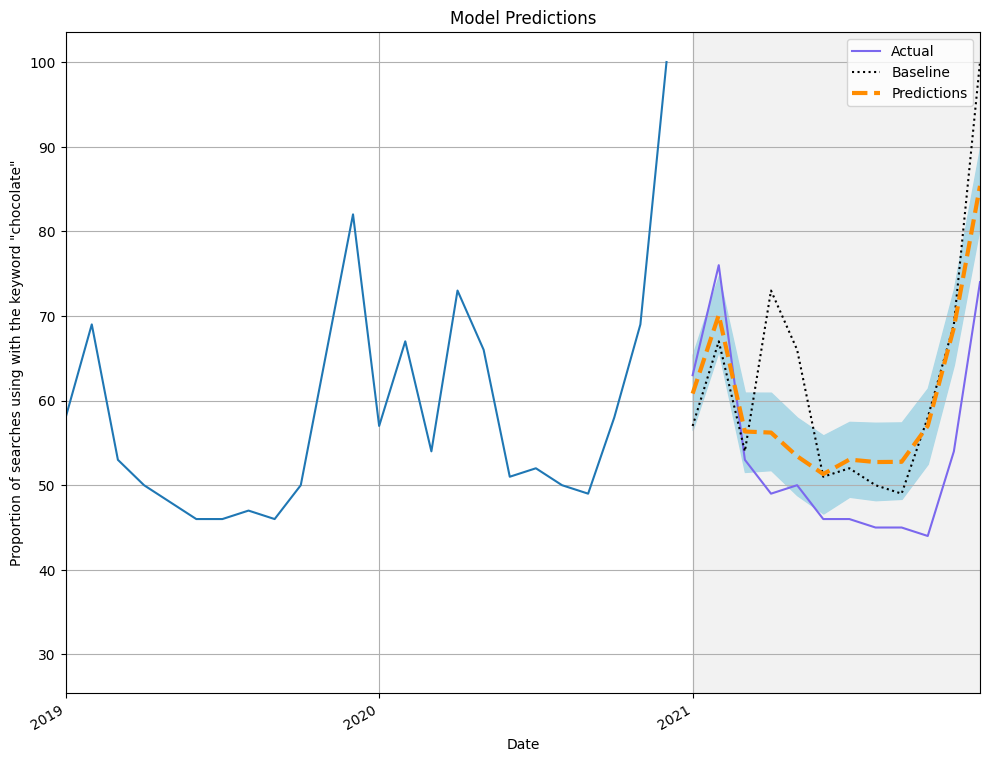

In [71]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], '-', color='mediumslateblue',label='Actual')
ax.plot(test['baseline'], 'k:', label='Baseline')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Predictions')

ax.set_xlabel('Date')
ax.set_ylabel('Proportion of searches using with the keyword "chocolate"')

ax.axvspan(204, 215, color='#808080', alpha=0.1)

ax.legend(loc='best')

plt.xticks(np.arange(0, 215, 12), np.arange(2004, 2022, 1))
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(180, 215)

fig.autofmt_xdate()
plt.tight_layout()
plt.title('Model Predictions')
plt.show()

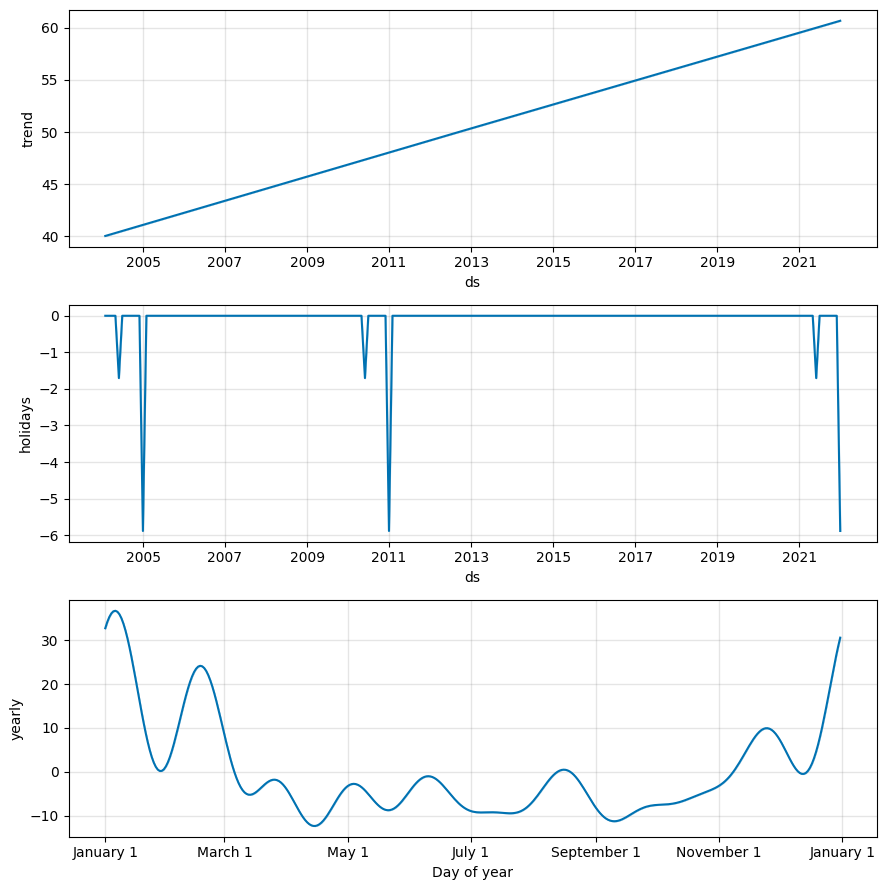

In [72]:
prophet_components_fig = m.plot_components(forecast)

### Can SARIMA do better?

##### Dickey-Fuller

In [74]:
ad_fuller_result = adfuller(df['y'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.0341743396012535
p-value: 0.2717927133166918


##### 1st Order Differencing

In [75]:
y_diff = np.diff(df['y'], n=1)

ad_fuller_result = adfuller(y_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -7.034710505102191
p-value: 6.058003360042041e-10


##### Setting SARIMAX Function

In [81]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

##### Setting Combinations

In [82]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 0
s = 12

##### Training on SARIMAX Function

In [83]:
SARIMA_result_df = optimize_SARIMAX(train['y'], None, order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(1, 2, 3, 1)",16.000000
1,"(3, 2, 1, 3)",35.133095
2,"(2, 2, 1, 3)",575.573054
3,"(1, 1, 1, 1)",1127.747036
4,"(1, 2, 1, 1)",1128.794164
...,...,...
247,"(1, 2, 0, 0)",1570.730422
248,"(2, 1, 0, 0)",1570.732139
249,"(0, 1, 0, 0)",1570.979692
250,"(0, 2, 0, 0)",1571.866177


##### Running SARIMAX Optimal Model Up & Getting Report

In [97]:
SARIMA_model = SARIMAX(train['y'], order=(1,1,1), seasonal_order=(1,0,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -558.874
Date:                            Sun, 10 Mar 2024   AIC                           1127.747
Time:                                    10:52:50   BIC                           1144.313
Sample:                                         0   HQIC                          1134.449
                                            - 204                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3601      0.078      4.643      0.000       0.208       0.512
ma.L1         -0.8950      0.051   

##### Diagnose Visualization

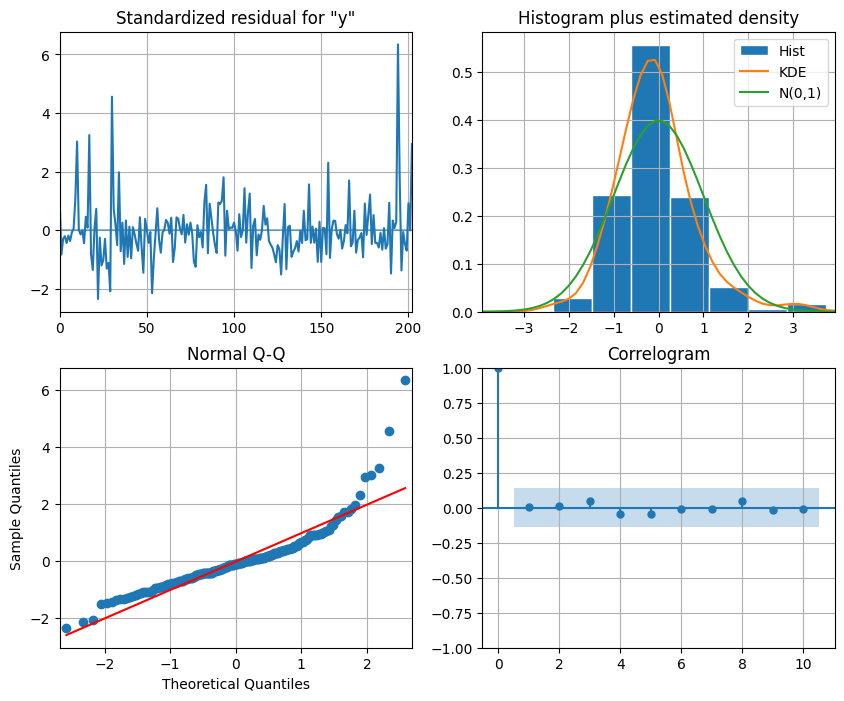

In [98]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

##### LJung-Box Procedure

In [99]:
# Running the Ljung-Box test on the residuals
residuals = SARIMA_model_fit.resid
results = acorr_ljungbox(residuals, lags=np.arange(1, 11, 1))

# Accessing the p-values from the results dictionary
pvalues = results['lb_pvalue']

print(pvalues)

1     0.044714
2     0.091406
3     0.187175
4     0.238136
5     0.236149
6     0.294012
7     0.397565
8     0.494141
9     0.511929
10    0.263035
Name: lb_pvalue, dtype: float64


In [100]:
test

,ds,y,yhat,yhat_lower,yhat_upper,baseline
204,2021-01-31,63,60.824610,56.531790,65.416119,57
205,2021-02-28,76,70.115673,65.885169,74.720469,67
206,2021-03-31,53,56.343246,51.564926,60.941857,54
207,2021-04-30,49,56.217290,51.783033,60.931379,73
208,2021-05-31,50,53.423253,48.813896,57.991110,66
209,2021-06-30,46,51.314305,46.653381,55.884071,51
210,2021-07-31,46,53.029352,48.632738,57.482609,52
211,2021-08-31,45,52.736334,48.228312,57.378701,50
212,2021-09-30,45,52.763314,48.385104,57.420912,49
213,2021-10-31,44,57.007518,52.526235,61.447089,58


In [101]:
SARIMA_pred = SARIMA_model_fit.get_prediction(204, 215).predicted_mean

test['SARIMA_pred'] = SARIMA_pred

test

,ds,y,yhat,yhat_lower,yhat_upper,baseline,SARIMA_pred
204,2021-01-31,63,60.824610,56.531790,65.416119,57,66.620793
205,2021-02-28,76,70.115673,65.885169,74.720469,67,74.228545
206,2021-03-31,53,56.343246,51.564926,60.941857,54,59.758322
207,2021-04-30,49,56.217290,51.783033,60.931379,73,60.472391
208,2021-05-31,50,53.423253,48.813896,57.991110,66,58.430683
209,2021-06-30,46,51.314305,46.653381,55.884071,51,53.698580
210,2021-07-31,46,53.029352,48.632738,57.482609,52,54.984286
211,2021-08-31,45,52.736334,48.228312,57.378701,50,54.297431
212,2021-09-30,45,52.763314,48.385104,57.420912,49,54.576436
213,2021-10-31,44,57.007518,52.526235,61.447089,58,59.527019


In [102]:
SARIMA_mae = mean_absolute_error(test['y'], test['SARIMA_pred'])

print(SARIMA_mae)

10.067670027991255
